# Table of Contents
 <p><div class="lev2 toc-item"><a href="#Dougenik,-Chrisman,-Niemayer-Cartogram-using-GeoPandas" data-toc-modified-id="Dougenik,-Chrisman,-Niemayer-Cartogram-using-GeoPandas"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Dougenik, Chrisman, Niemayer Cartograms using GeoPandas</a></div><div class="lev1 toc-item"><a href="#Usage" data-toc-modified-id="Usage-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Usage</a></div><div class="lev1 toc-item"><a href="#Notes" data-toc-modified-id="Notes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Notes</a></div><div class="lev1 toc-item"><div class="lev1 toc-item"><a href="#ToDo" data-toc-modified-id="Examples-3"><span class="toc-item-num">4&nbsp;&nbsp;</span>ToDo</a></div><a href="#References" data-toc-modified-id="References-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>References</a></div><div class="lev1 toc-item"><a href="#Examples" data-toc-modified-id="Examples-3"><span class="toc-item-num">4&nbsp;&nbsp;</span>Examples</a></div>

# Dougenik, Chrisman, Niemayer Cartogram using GeoPandas
## Usage

The basic function accepts a GeoPandas GeoDataFrame and the column name of the field for which you want to create a Dougenik, Chrisman, Niemayer cartogram.

Currently, a stopping rule has not been implemented, therefore a trial-and-error approach is required to arrive at a suitable number of iterations. Generally a good solution requires more than 20 iterations. The verbose option prints out the current iteration and error, a suitable number of iterations is generally arrived at when both mean error and the largest single error approach one. The precision of the error after 1 is effectively the percentage error - 1.16 = 16% error between desired and actual area.

As the output is a GeoPandas GeoDataFrame, plotting is straightforward using the built-in .plot() method.

NB The field used for creating the Dougenik, Chrisman, Niemayer cartogram should contain values which are positive and greater than zero. It is important that the input data be in a projected (Cartesian) coordinate system. The GeoDataFrame should be structured so that 1 row is 1 record.

## Notes

The pseudocode for computing the cartogram is given in the reference cited, and is as follows:

`For each polygon
    Read and store PolygonValue (negative value illegal)
    Sum PolygonValue into TotalValue
For each iteration (user controls when done)
    For each polygon
        Calculate area and centroid (using current boundaries)
    Sum areas into TotalArea
    For each polygon
        Desired = (TotalArea * (PolygonValue/TotalValue))
        Radius = SquareRoot(Area/pi)
        Mass = SquareRoot(Desired/pi) - SquareRoot(Area/pi)
        SizeError = Max(Area, Desired) / Min(Area, Desired)
    ForceReductionFactor = 1 / (1 + Mean(SizeError))
    For each boundary line; Read coordinate chain
        For each coordinate pair
            For each polygon centroid
                Find angle, Distance from centroid to coordinate
                If (Distance > Radius of polygon)
                    Fij = Mass * (Radius/Distance)
                Else
                    Fij = Mass * (Distance`$^{2}$` / Radius`$^{2}$`) * (4 - (3 *(Distance / Radius)))
            Using Fij and angles, calculate vector sum
            Multiply by ForceReductionFactor
            Move coordinate accordingly
        Write distorted line to output and plot result`

## ToDo

1. Stopping rule
2. Improve efficiency of code (i.e. vectorize nested loop of point movements)
3. Extend algorithm to include polygon interior if present (currently polygon interiors will disappear)

## References

Dougenik J., Chrisman N. and Niemeyer D. 1985. An algorithm to construct continuous area cartograms. Professional Geographer. 37(1): 75-81.

## Examples

In [1]:
# Some required libraries.
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# import the non-contiguous cartogram function
from cartogrampy.dcn_cartogram import dcn_cartogram

%matplotlib inline

In [2]:
# Get some data for London
# Read in London Boroughs geojson and project to British National Grid.
ldn_boro = gpd.read_file('data/LDN_Boro.geojson').to_crs(epsg=27700)

# Get some population data for London Boroughs
ldn_pop = pd.read_excel('data/Pandas_Lon_Pop.xlsx')

# Merge the population data with the geospatial data
ldn_boro = ldn_boro.merge(ldn_pop, how='left', left_on='GSS_CODE', right_on='New Code')

In [3]:
# Compute DCN Cartogram - max error c. 4% after 10 iterations, after 16 < 1%.
ldn_dcn = dcn_cartogram(ldn_boro,2015,iterations=16,verbose=False)

(501045.30381407775,
 563484.43901558267,
 153647.76433900016,
 203384.75776296182)

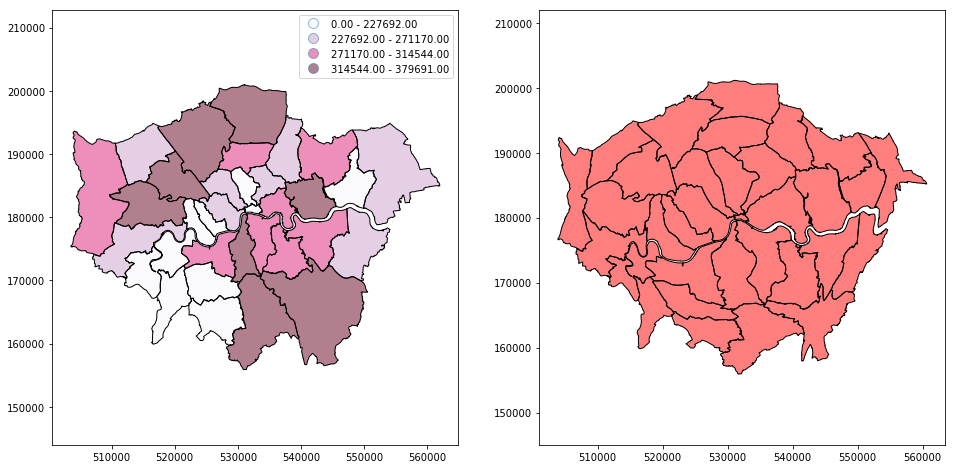

In [4]:
# Map the outcome
fig, ax = plt.subplots(1,2,figsize=(16,8))
ldn_boro.plot(column = 2015,cmap = 'PuRd', scheme = 'Quantiles', k=4,legend=True, ax=ax[0])
ldn_dcn.plot(color='r',ax=ax[1])
ax[0].axis('equal')
ax[1].axis('equal')

In [5]:
# Get some data for US States
usstate = gpd.read_file('data/US_State_2016_5m.geojson')

# Set crs
usstate.crs = {'init': u'epsg:4269'}

# Get continental US and project to NAD83 Contiguous US Albers.
usstate = usstate[~usstate['STUSPS'].isin(['AK', 'HI', 'AS', 'PR',
                                           'GU', 'MP', 'VI'])].to_crs({'init': 'epsg:5070'})
# Read in state populations
state_pop = pd.read_excel('data/Pandas_US_Pop.xlsx')

# Merge population data
usstate = usstate.merge(state_pop, how='left', left_on='STUSPS', right_on='Code')

In [6]:
# Compute DCN Cartogram - max error c. 35% after 10 iterations, after 20 c.8%., after 30 c. 4%
us_dcn = dcn_cartogram(usstate,2016,iterations=30,verbose=True)

iteration: 1 Mean Error: 4.139625686 Max Error: 56.0636732509
iteration: 2 Mean Error: 3.07686394859 Max Error: 31.4452145911
iteration: 3 Mean Error: 2.33483404478 Max Error: 17.4568573151
iteration: 4 Mean Error: 1.82346344615 Max Error: 9.49989507624
iteration: 5 Mean Error: 1.48267102375 Max Error: 4.74010091127
iteration: 6 Mean Error: 1.28314101497 Max Error: 2.63111925969
iteration: 7 Mean Error: 1.17080838374 Max Error: 1.92379115853
iteration: 8 Mean Error: 1.10677270104 Max Error: 1.6357838411
iteration: 9 Mean Error: 1.06920802484 Max Error: 1.45916806884
iteration: 10 Mean Error: 1.04669058772 Max Error: 1.34603139542
iteration: 11 Mean Error: 1.03266220617 Max Error: 1.27054476497
iteration: 12 Mean Error: 1.02395322326 Max Error: 1.21834779666
iteration: 13 Mean Error: 1.01842689862 Max Error: 1.18110706301
iteration: 14 Mean Error: 1.01459217296 Max Error: 1.15376972395
iteration: 15 Mean Error: 1.01191988371 Max Error: 1.1331511953
iteration: 16 Mean Error: 1.0098929418

(-2410025.9882700895,
 2553588.285652841,
 745.22445129277185,
 3285698.0291891452)

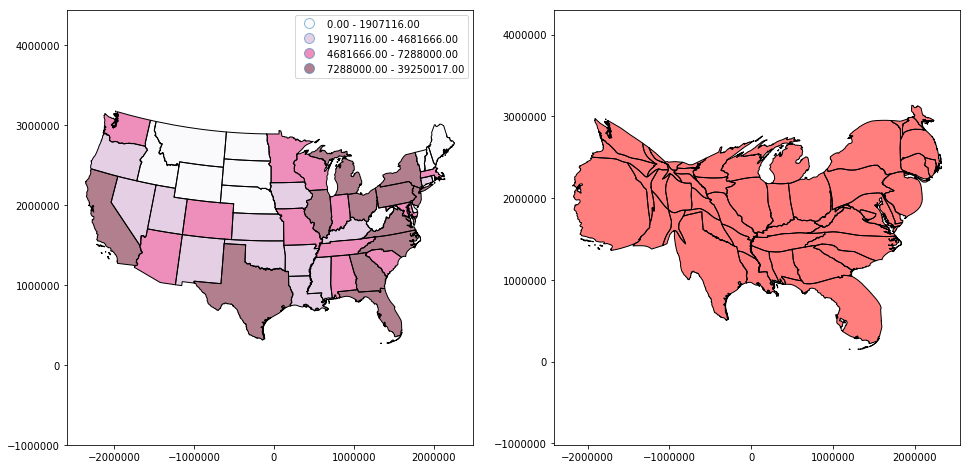

In [7]:
# Map the outcome
fig, ax = plt.subplots(1,2,figsize=(16,8))
usstate.plot(column = 2016,cmap = 'PuRd', scheme = 'Quantiles', k=4,legend=True, ax=ax[0])
us_dcn.plot(color='r',ax=ax[1])
ax[0].axis('equal')
ax[1].axis('equal')